# Group Members
# Tirth Patel
# Nachiket Prajapati
# Priyank Patel
# Neel Patel

In [ ]:
import os
import zipfile
import torch
import pandas as pd
from PIL import Image
from torchvision import models, transforms
from tqdm import tqdm

# Step 1: Extract flowers.zip
zip_path = "/content/flowers.zip"  # Path to the zip file
extracted_path = "/content/flowers/flowers/flowers/flowers"  # Directory to extract images

# Unzip the file
if os.path.exists(zip_path):
    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extracted_path)
        print(f"Extracted {zip_path} to {extracted_path}")
    except zipfile.BadZipFile:
        print("Error: The zip file is invalid or corrupted.")
        raise
else:
    raise FileNotFoundError(f"Zip file not found at {zip_path}")

# Step 2: Set up the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Step 3: Load pre-trained ResNet18 model
model = models.resnet18(pretrained=True)
model = model.to(device)
model.eval()  # Set the model to evaluation mode

# Step 4: Define image preprocessing
preprocess = transforms.Compose([
    transforms.Resize(256),  # Resize image to 256x256 pixels
    transforms.CenterCrop(224),  # Center crop to 224x224
    transforms.ToTensor(),  # Convert image to PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Normalize
])

# Step 5: Function to extract features from a single image
def extract_features(image_path):
    try:
        # Load and preprocess the image
        img = Image.open(image_path).convert('RGB')  # Convert image to RGB
        img = preprocess(img)  # Apply preprocessing
        img = img.unsqueeze(0).to(device)  # Add batch dimension and move to device

        # Extract features using the model
        with torch.no_grad():
            features = model(img)
        return features.cpu().numpy().flatten()  # Return flattened features
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None

# Step 6: Process all images in the folder
data = []
if os.path.exists(extracted_path):
    print(f"Processing images in {extracted_path}...")
    for filename in tqdm(os.listdir(extracted_path)):
        file_path = os.path.join(extracted_path, filename)
        if filename.lower().endswith(('png', 'jpg', 'jpeg')):  # Check for valid image formats
            features = extract_features(file_path)  # Extract features
            if features is not None:
                data.append([filename] + features.tolist())  # Add filename and features
else:
    raise FileNotFoundError(f"Extracted folder not found at {extracted_path}")

# Step 7: Save extracted features to a CSV file
if data:  # Check if any features were extracted
    # Create a DataFrame to store the features
    columns = ['filename'] + [f'feature_{i}' for i in range(len(data[0]) - 1)]
    df = pd.DataFrame(data, columns=columns)

    # Save DataFrame to CSV
    csv_output_path = "/content/image_features.csv"
    df.to_csv(csv_output_path, index=False)
    print(f"Feature extraction complete. Features saved to {csv_output_path}")
else:
    print("No features were extracted. Ensure the images are valid and the model is working correctly.")


Extracted /content/flowers.zip to /content/flowers/flowers/flowers/flowers
Processing images in /content/flowers/flowers/flowers/flowers...


100%|██████████| 3670/3670 [00:31<00:00, 115.48it/s]


Feature extraction complete. Features saved to /content/image_features.csv


DBSCAN found 5 clusters.
Noise points: 3659
K-Means Silhouette Score: 0.07664324910111514
DBSCAN Silhouette Score: -0.2512067270462963
Agglomerative Silhouette Score: 0.045910814998458255


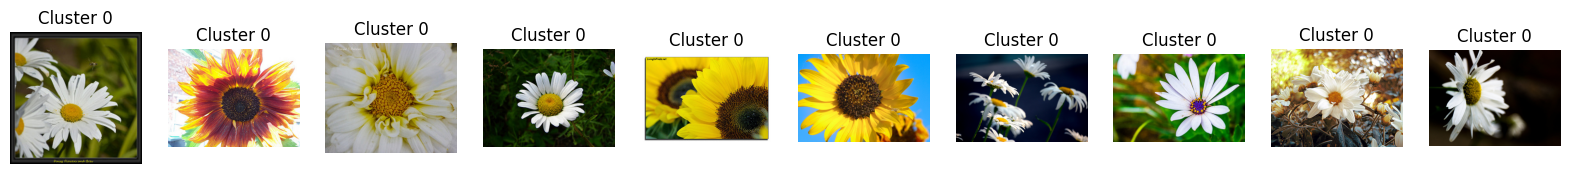

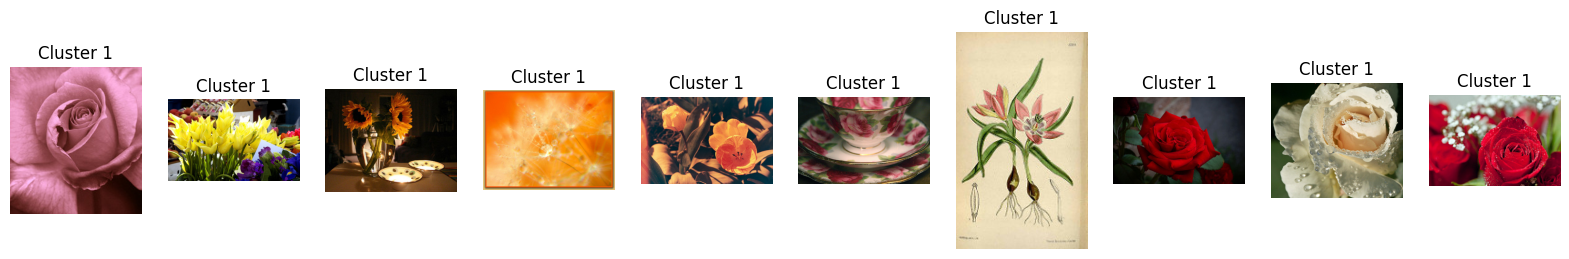

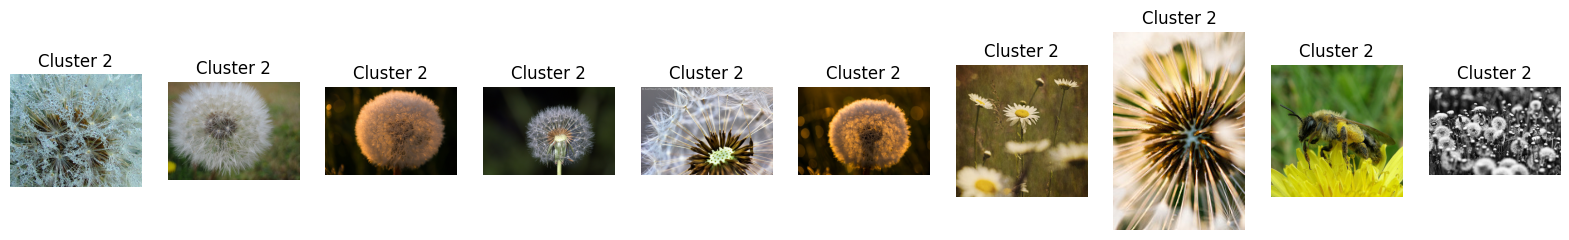

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import random
import shutil

# Step 1: Load Precomputed Features

# Load features from CSV
csv_path = "/content/image_features.csv"  # Update the path to  CSV file
data = pd.read_csv(csv_path)

# Extract features and filenames
filenames = data['filename'].values
features = data.drop(columns=['filename']).values

# Step 2: Standardize Features for Clustering
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Optional: Dimensionality Reduction for Better DBSCAN Clustering
pca = PCA(n_components=10)  # Reduce to 10 dimensions
features_reduced = pca.fit_transform(features_scaled)

# Step 3: Clustering

# Function to perform clustering
def cluster_images(features, filenames, algorithm, **kwargs):
    if algorithm == "kmeans":
        cluster_model = KMeans(**kwargs)
    elif algorithm == "dbscan":
        cluster_model = DBSCAN(**kwargs)
    elif algorithm == "agglomerative":
        cluster_model = AgglomerativeClustering(**kwargs)
    else:
        raise ValueError("Unsupported algorithm")

    labels = cluster_model.fit_predict(features)
    cluster_mapping = {}
    for idx, label in enumerate(labels):
        if label not in cluster_mapping:
            cluster_mapping[label] = []
        cluster_mapping[label].append(filenames[idx])

    return cluster_mapping, labels

# Perform clustering
kmeans_mapping, kmeans_labels = cluster_images(features, filenames, "kmeans", n_clusters=5)
agg_mapping, agg_labels = cluster_images(features, filenames, "agglomerative", n_clusters=5)
dbscan_mapping, dbscan_labels = cluster_images(features_reduced, filenames, "dbscan", eps=2.0, min_samples=2)

# Step 4: Check DBSCAN Results
unique_labels = set(dbscan_labels)
print(f"DBSCAN found {len(unique_labels) - (1 if -1 in unique_labels else 0)} clusters.")
print(f"Noise points: {list(dbscan_labels).count(-1)}")

# Step 5: Evaluate Clustering

# Function to evaluate clustering using silhouette score
def evaluate_clustering(features, labels):
    if len(set(labels)) > 1:  # At least two clusters required
        score = silhouette_score(features, labels)
        return score
    else:
        return "Cannot compute silhouette score with only one cluster."

# Evaluate clustering performance
kmeans_score = evaluate_clustering(features, kmeans_labels)
dbscan_score = evaluate_clustering(features_reduced, dbscan_labels)
agg_score = evaluate_clustering(features, agg_labels)

print(f"K-Means Silhouette Score: {kmeans_score}")
print(f"DBSCAN Silhouette Score: {dbscan_score}")
print(f"Agglomerative Silhouette Score: {agg_score}")

# Step 6: Move Images into Clusters

# Function to move clustered images into separate folders
def move_images_to_folders(cluster_mapping, image_folder, output_folder):
    os.makedirs(output_folder, exist_ok=True)
    for cluster_id, filenames in cluster_mapping.items():
        cluster_folder = os.path.join(output_folder, f"cluster_{cluster_id}")
        os.makedirs(cluster_folder, exist_ok=True)
        for filename in filenames:
            src_path = os.path.join(image_folder, filename)
            dest_path = os.path.join(cluster_folder, filename)
            shutil.copy(src_path, dest_path)

# Move images into clusters
image_folder = "/content/flowers/flowers/flowers/flowers"  # Update the path to your images folder
output_folder = "/content/clustered_images_trial_Final_02"
move_images_to_folders(kmeans_mapping, image_folder, os.path.join(output_folder, "kmeans"))
move_images_to_folders(dbscan_mapping, image_folder, os.path.join(output_folder, "dbscan"))
move_images_to_folders(agg_mapping, image_folder, os.path.join(output_folder, "agglomerative"))

# Step 7: Visualize Clusters

# Function to visualize clusters with random images
def visualize_clusters(cluster_mapping, image_folder, num_clusters=3):
    largest_clusters = sorted(cluster_mapping.keys(), key=lambda x: len(cluster_mapping[x]), reverse=True)[:num_clusters]

    for cluster_id in largest_clusters:
        fig, axes = plt.subplots(1, min(len(cluster_mapping[cluster_id]), 10), figsize=(20, 5))
        for i, filename in enumerate(random.sample(cluster_mapping[cluster_id], min(len(cluster_mapping[cluster_id]), 10))):
            img_path = os.path.join(image_folder, filename)
            img = plt.imread(img_path)
            axes[i].imshow(img)
            axes[i].axis('off')
            axes[i].set_title(f"Cluster {cluster_id}")
        plt.show()

# Visualize clusters
visualize_clusters(kmeans_mapping, image_folder,num_clusters=3)


Explained Variance Ratio: 0.67
Finding optimal K using Elbow Method...


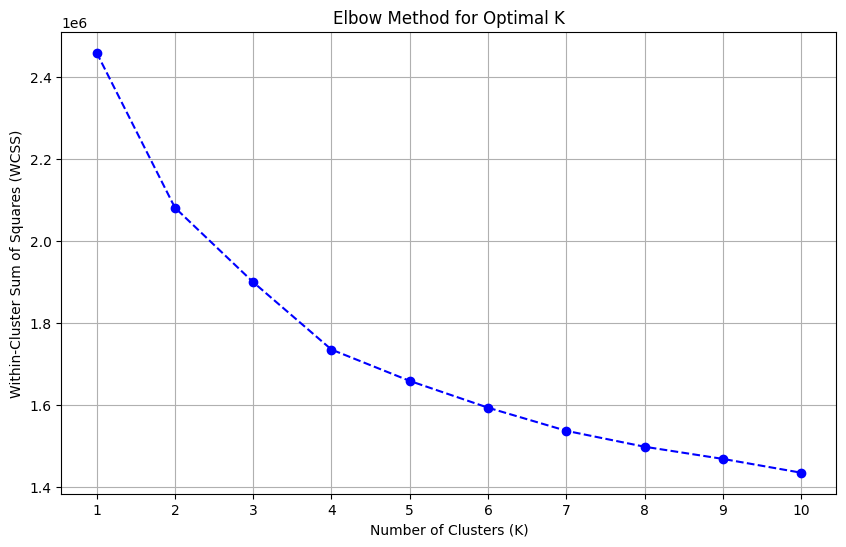

Validating with Silhouette Scores...
K=2, Silhouette Score=0.1421
K=3, Silhouette Score=0.1285
K=4, Silhouette Score=0.1249
K=5, Silhouette Score=0.1189
K=6, Silhouette Score=0.1141
K=7, Silhouette Score=0.1097
K=8, Silhouette Score=0.1005
K=9, Silhouette Score=0.0930
K=10, Silhouette Score=0.0921


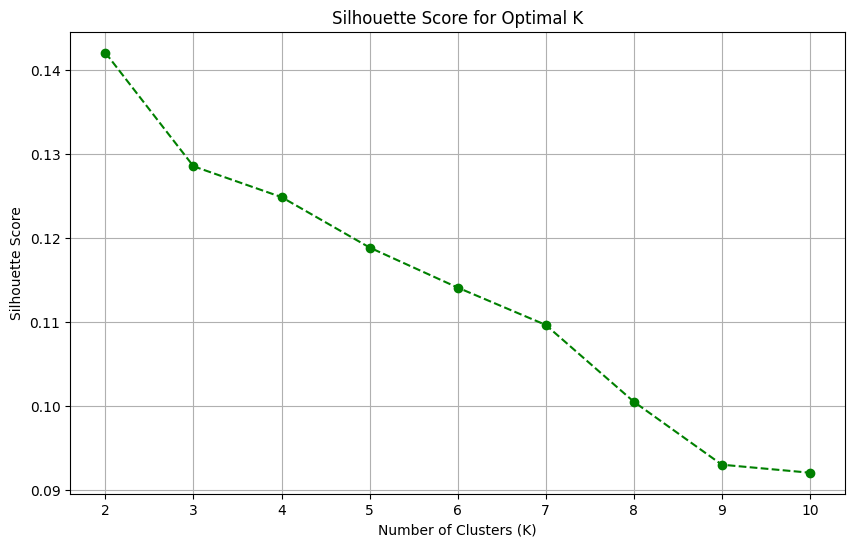

Optimal K determined by Silhouette Score: 2
Images moved into clusters in /content/kmeans_optimal_clusters


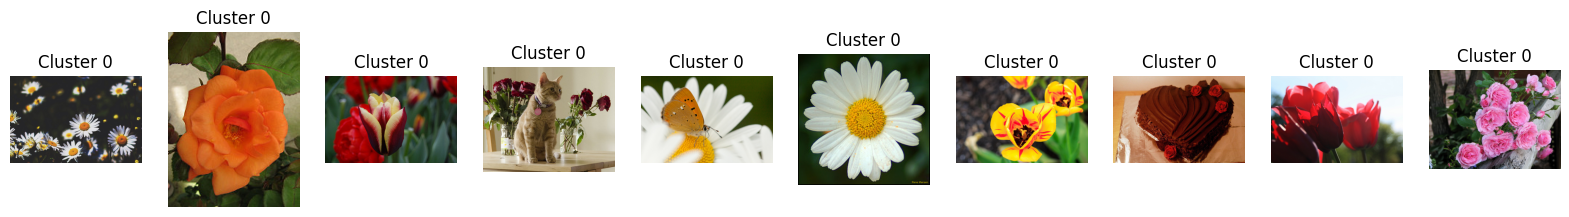

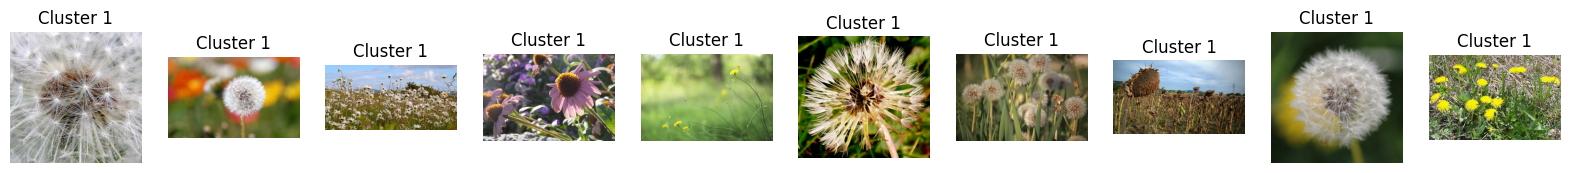

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import shutil
import random

# Step 1: Load Precomputed Features
csv_path = "/content/image_features.csv"  # Path to features CSV
data = pd.read_csv(csv_path)

# Extract filenames and features
filenames = data['filename'].values
features = data.drop(columns=['filename']).values

# Step 2: Standardize Features
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Step 3: Dimensionality Reduction (Optional)
pca = PCA(n_components=20)  # Retain more variance
features_reduced = pca.fit_transform(features_scaled)
print(f"Explained Variance Ratio: {sum(pca.explained_variance_ratio_):.2f}")

# Step 4: Elbow Method to Find Optimal K
def elbow_method(features, max_k=10):
    wcss = []  # List to store WCSS values
    k_values = range(1, max_k + 1)

    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42, init='k-means++')
        kmeans.fit(features)
        wcss.append(kmeans.inertia_)  # Inertia is the WCSS

    return k_values, wcss

print("Finding optimal K using Elbow Method...")
k_values, wcss = elbow_method(features_reduced, max_k=10)

# Plot the Elbow Method results
plt.figure(figsize=(10, 6))
plt.plot(k_values, wcss, marker='o', linestyle='--', color='b')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Within-Cluster Sum of Squares (WCSS)')
plt.title('Elbow Method for Optimal K')
plt.xticks(k_values)
plt.grid(True)
plt.show()

# Step 5: Silhouette Scores for Validation
def find_optimal_k_silhouette(features, min_k=2, max_k=10):
    silhouette_scores = []
    k_values = range(min_k, max_k + 1)
    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42, init='k-means++')
        labels = kmeans.fit_predict(features)
        score = silhouette_score(features, labels)
        silhouette_scores.append(score)
        print(f"K={k}, Silhouette Score={score:.4f}")
    optimal_k = k_values[silhouette_scores.index(max(silhouette_scores))]
    return k_values, silhouette_scores, optimal_k

print("Validating with Silhouette Scores...")
silhouette_k_values, silhouette_scores, optimal_k = find_optimal_k_silhouette(features_reduced, min_k=2, max_k=10)

# Plot Silhouette Scores
plt.figure(figsize=(10, 6))
plt.plot(silhouette_k_values, silhouette_scores, marker='o', linestyle='--', color='g')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for Optimal K')
plt.xticks(silhouette_k_values)
plt.grid(True)
plt.show()

print(f"Optimal K determined by Silhouette Score: {optimal_k}")

# Step 6: Perform KMeans Clustering with Optimal K
kmeans_model = KMeans(n_clusters=optimal_k, random_state=42, init='k-means++')
kmeans_labels = kmeans_model.fit_predict(features_reduced)

# Step 7: Map Images to Clusters
def map_clusters_to_images(labels, filenames):
    cluster_mapping = {}
    for idx, label in enumerate(labels):
        if label not in cluster_mapping:
            cluster_mapping[label] = []
        cluster_mapping[label].append(filenames[idx])
    return cluster_mapping

kmeans_mapping = map_clusters_to_images(kmeans_labels, filenames)

# Step 8: Organize Images into Folders
def move_images_to_folders(cluster_mapping, image_folder, output_folder):
    os.makedirs(output_folder, exist_ok=True)
    for cluster_id, filenames in cluster_mapping.items():
        cluster_folder = os.path.join(output_folder, f"cluster_{cluster_id}")
        os.makedirs(cluster_folder, exist_ok=True)
        for filename in filenames:
            src_path = os.path.join(image_folder, filename)
            dest_path = os.path.join(cluster_folder, filename)
            shutil.copy(src_path, dest_path)

image_folder = "/content/flowers/flowers/flowers/flowers/flowers"
output_folder = "/content/kmeans_optimal_clusters"
move_images_to_folders(kmeans_mapping, image_folder, output_folder)

print(f"Images moved into clusters in {output_folder}")

# Step 9: Visualize Clusters
def visualize_clusters(cluster_mapping, image_folder, num_clusters=3):
    largest_clusters = sorted(cluster_mapping.keys(), key=lambda x: len(cluster_mapping[x]), reverse=True)[:num_clusters]

    for cluster_id in largest_clusters:
        fig, axes = plt.subplots(1, min(len(cluster_mapping[cluster_id]), 10), figsize=(20, 5))
        for i, filename in enumerate(random.sample(cluster_mapping[cluster_id], min(len(cluster_mapping[cluster_id]), 10))):
            img_path = os.path.join(image_folder, filename)
            img = plt.imread(img_path)
            axes[i].imshow(img)
            axes[i].axis('off')
            axes[i].set_title(f"Cluster {cluster_id}")
        plt.show()

visualize_clusters(kmeans_mapping, image_folder, num_clusters=min(3, optimal_k))
